# Steam Games EDA

**Gjord av:** Rasmus och Oliver  
**Mål:** Undersök, städa och analysera datasettet för att förstå relationer, mönster och drag som kan användas i content-based, collaborativt och hybrind rekomendationssystem.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

plt.style.use("ggplot")
sns.set_theme()
pd.set_option('display.max_columns', None)


## 2. Ladda in datan och lägg ihop det
Vi har tre olika filer med data:
- `games.csv`: Basinfo (title, ratings, prices, etc.)
- `games_metadata.json`: descriptioner och tags
- `recommendations.csv`: användarrecensioner, speltid och rekommendationssignaler (41M rader, kommer att aggregeras i segment)


In [ ]:
# Load datasets 
df_games = pd.read_csv("data/games.csv")
print("Base:", df_games.shape)

df_meta = pd.read_json("data/games_metadata.json", lines=True)
print("Metadata:", df_meta.shape)

use_cols = ['app_id', 'is_recommended', 'hours', 'helpful', 'funny']
chunksize = 5_000_000

agg_dict = {}

for chunk in pd.read_csv("data/recommendations.csv", usecols=use_cols, chunksize=chunksize):
    grouped = chunk.groupby('app_id').agg(
        reviews=('is_recommended', 'count'),
        rec_true=('is_recommended', lambda x: x.sum()),
        avg_hours=('hours', 'mean'),
        avg_helpful=('helpful', 'mean'),
        avg_funny=('funny', 'mean')
    )
    for app_id, row in grouped.iterrows():
        if app_id not in agg_dict:
            agg_dict[app_id] = row.to_dict()
        else:
            for key in row.index:
                agg_dict[app_id][key] += row[key]

df_recs_agg = pd.DataFrame.from_dict(agg_dict, orient='index').reset_index().rename(columns={'index': 'app_id'})
df_recs_agg['recommend_ratio'] = df_recs_agg['rec_true'] / df_recs_agg['reviews']

print("Aggregated recommendations:", df_recs_agg.shape)

Base: (50872, 13)
Metadata: (50872, 3)
Aggregated recommendations: (37610, 7)


## 3. Slå ihop alla dataset till en DataFrame


In [ ]:
df = (
    df_games
    .merge(df_meta, on="app_id", how="left")
    .merge(df_recs_agg, on="app_id", how="left")
)

print("Final merged DataFrame:", df.shape)
df.head()

✅ Final merged DataFrame: (50872, 21)


,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags,reviews,rec_true,avg_hours,avg_helpful,avg_funny,recommend_ratio
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre...",1686.0,1426.0,65.880744,35.637519,2.421487,0.845789
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True,,[Action],NaN,NaN,NaN,NaN,NaN,NaN
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St...",6943.0,6308.0,65.155396,11.129115,0.954360,0.908541
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P...",877.0,549.0,41.602561,22.028725,2.724621,0.625998
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra...",4850.0,4295.0,138.185020,32.057689,9.302946,0.885567


## 4. Städning av data och data preparation
Konvertera datatyper, mappa betygsetiketter till numeriska värden och extrahera årtal för trendanalys.


In [ ]:

df['date_release'] = pd.to_datetime(df['date_release'], errors='coerce')
df['year'] = df['date_release'].dt.year

rating_map = {
    'Overwhelmingly Positive': 9, 'Very Positive': 8, 'Positive': 7,
    'Mostly Positive': 6, 'Mixed': 5, 'Mostly Negative': 4,
    'Negative': 3, 'Very Negative': 2, 'Overwhelmingly Negative': 1
}
df['rating_score'] = df['rating'].map(rating_map)

df['computed_discount'] = np.where(
    df['price_original'] > 0,
    (df['price_original'] - df['price_final']) / df['price_original'],
    0
)

df['computed_discount'] = df['computed_discount'].clip(0, 1)
df['discount'] = df['computed_discount']

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   app_id             50872 non-null  int64         
 1   title              50872 non-null  object        
 2   date_release       50872 non-null  datetime64[ns]
 3   win                50872 non-null  bool          
 4   mac                50872 non-null  bool          
 5   linux              50872 non-null  bool          
 6   rating             50872 non-null  object        
 7   positive_ratio     50872 non-null  int64         
 8   user_reviews       50872 non-null  int64         
 9   price_final        50872 non-null  float64       
 10  price_original     50872 non-null  float64       
 11  discount           50872 non-null  float64       
 12  steam_deck         50872 non-null  bool          
 13  description        50872 non-null  object        
 14  tags  

## 5. Grundläggande översikt


In [46]:
print("Number of games:", len(df))
print("Average rating:", df['positive_ratio'].mean())
print("Average price (€):", df['price_final'].mean())
print("Average discount (%):", df['discount'].mean() * 100)
print("Average recommendation ratio:", df['recommend_ratio'].mean())


Number of games: 50872
Average rating: 77.0520325522881
Average price (€): 8.620324933165591
Average discount (%): 5.606336518850856
Average recommendation ratio: 0.7674406687021826


## 6. Egenskapsfördelningar
Utforska numeriska kolumner för att förstå datats form och skevheter.


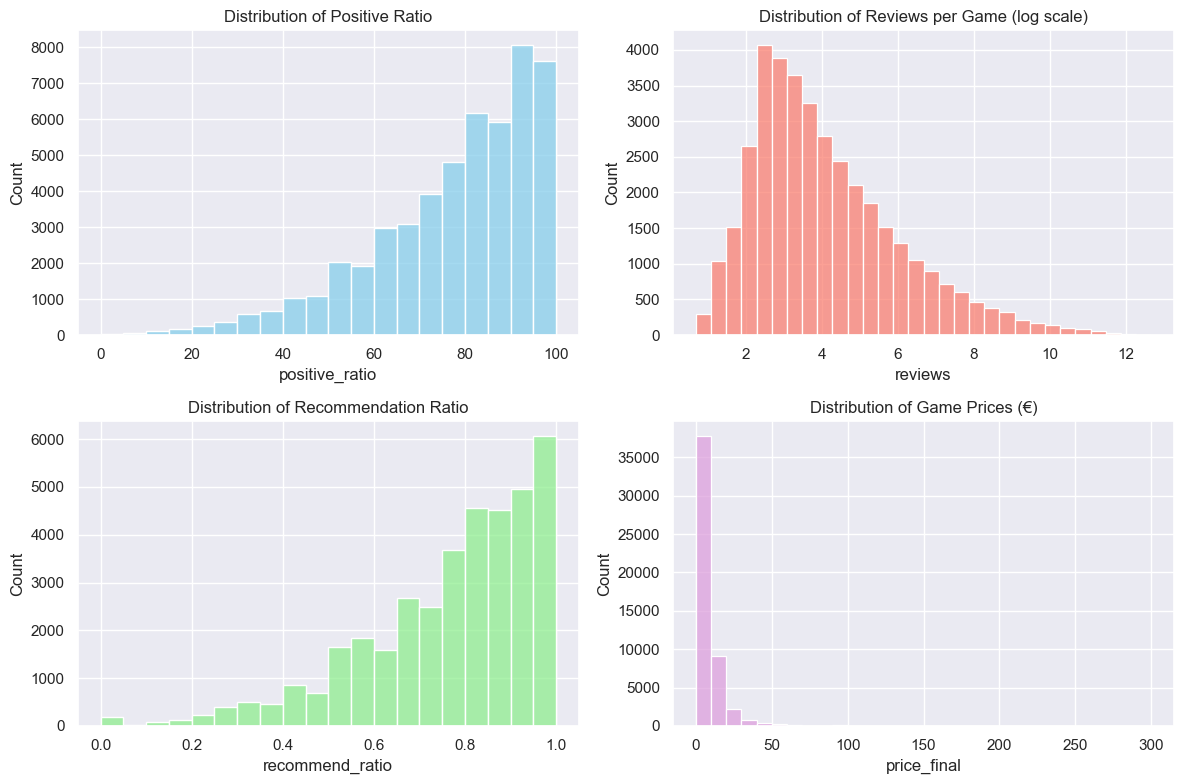

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(df['positive_ratio'], bins=20, ax=axes[0,0], color='skyblue')
axes[0,0].set_title("Distribution of Positive Ratio")

sns.histplot(np.log1p(df['reviews']), bins=30, ax=axes[0,1], color='salmon')
axes[0,1].set_title("Distribution of Reviews per Game (log scale)")

sns.histplot(df['recommend_ratio'], bins=20, ax=axes[1,0], color='lightgreen')
axes[1,0].set_title("Distribution of Recommendation Ratio")

sns.histplot(df['price_final'], bins=30, ax=axes[1,1], color='plum')
axes[1,1].set_title("Distribution of Game Prices (€)")

plt.tight_layout()
plt.show()


## 7. Correlations Matrix
Vi analyserar förhållandet mellan viktiga numeriska egenskaper.

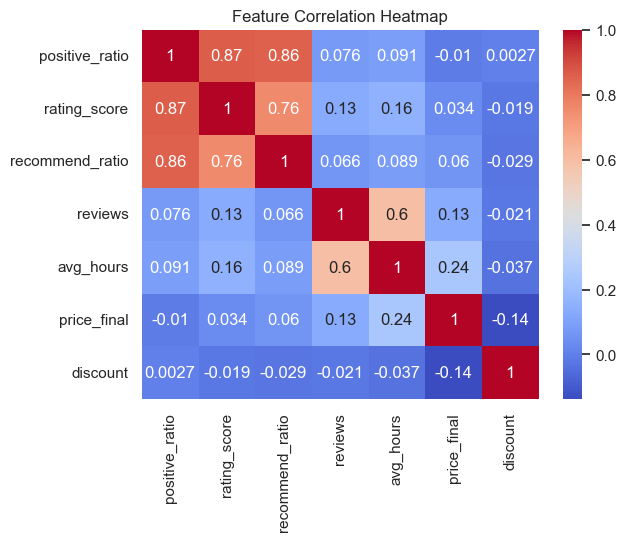

In [30]:
corr = df[['positive_ratio', 'rating_score', 'recommend_ratio', 'reviews', 'avg_hours', 'price_final', 'discount']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

## 8. Temporala trender
Siffran av spel som kommit ut och recensionernas trend över en tidsperiond.

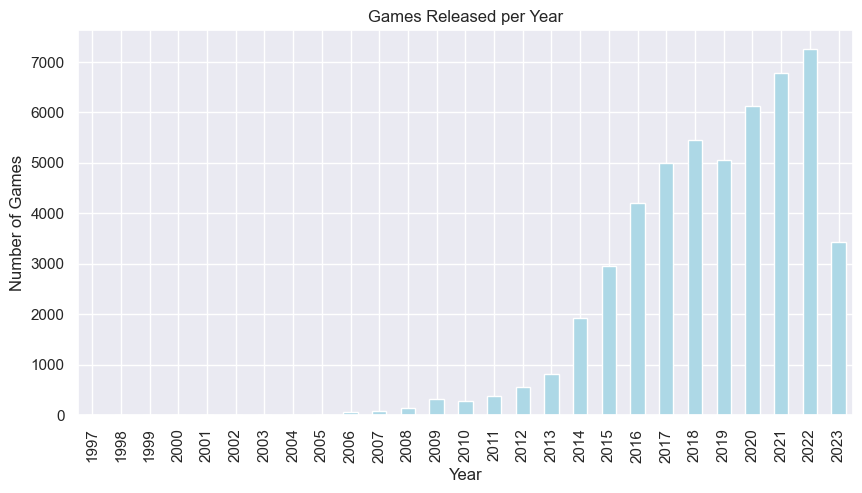

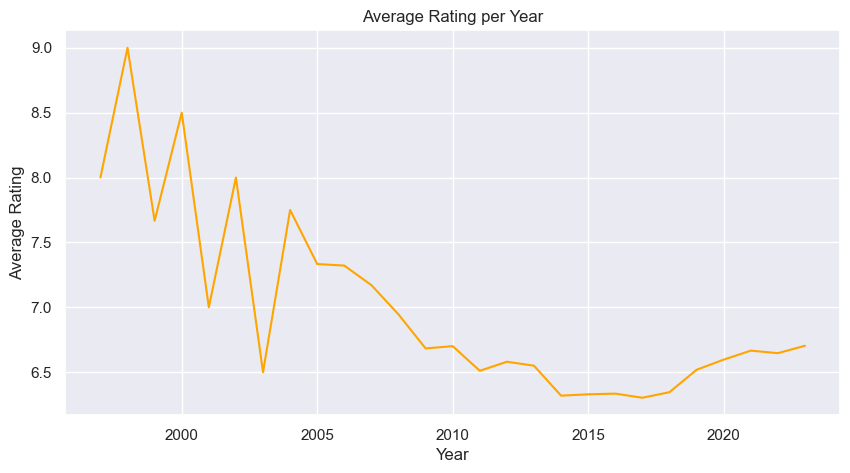

In [42]:
games_per_year = df.groupby('year').size()
avg_rating_year = df.groupby('year')['rating_score'].mean()

fig, ax1 = plt.subplots(figsize=(10,5))
games_per_year.plot(kind='bar', color='lightblue', ax=ax1, label="Games Released")
plt.title("Games Released per Year")
plt.xlabel("Year")
plt.ylabel("Number of Games")
plt.show()

avg_rating_year.plot(kind='line', color='orange', figsize=(10,5), title="Average Rating per Year")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.show()


## 9. Platform tillgänglighet


C:\Users\rasmu\AppData\Local\Temp\ipykernel_20872\3391238983.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=platform_counts.index, y=platform_counts.values, palette="viridis")


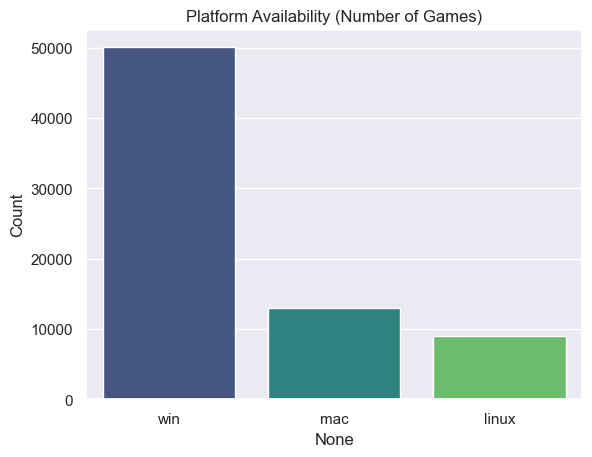

In [32]:
platform_counts = df[['win', 'mac', 'linux']].sum().sort_values(ascending=False)
sns.barplot(x=platform_counts.index, y=platform_counts.values, palette="viridis")
plt.title("Platform Availability (Number of Games)")
plt.ylabel("Count")
plt.show()


## 10. Analys av beskrivningar och taggar


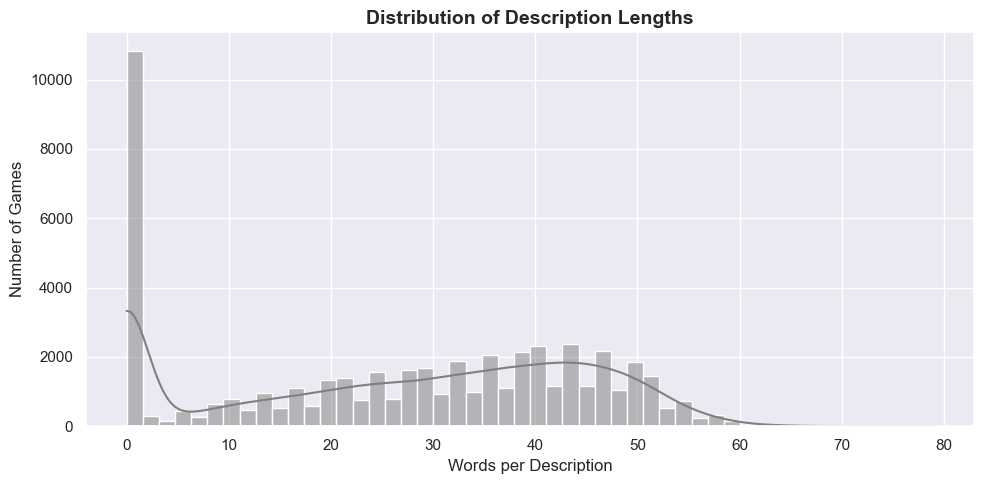

Average description length: 26.58702233055512
Median description length: 30.0


In [ ]:
df['desc_length'] = df['description'].apply(
    lambda x: len(str(x).split()) if isinstance(x, str) else 0
)

plt.figure(figsize=(10,5))
sns.histplot(df['desc_length'], bins=50, kde=True, color='gray')
plt.title("Distribution of Description Lengths", fontsize=14, weight='bold')
plt.xlabel("Words per Description", fontsize=12)
plt.ylabel("Number of Games", fontsize=12)
plt.tight_layout()
plt.show()

print("Average description length:", df['desc_length'].mean())
print("Median description length:", df['desc_length'].median())

C:\Users\rasmu\AppData\Local\Temp\ipykernel_20872\3463520864.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Tag', data=tag_df, palette='mako')


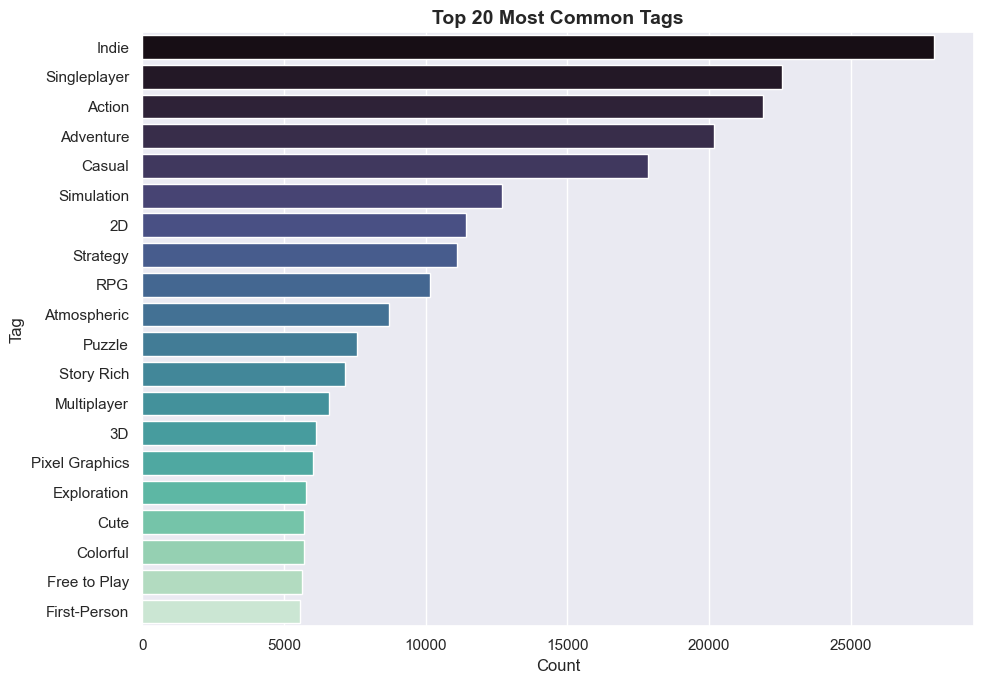

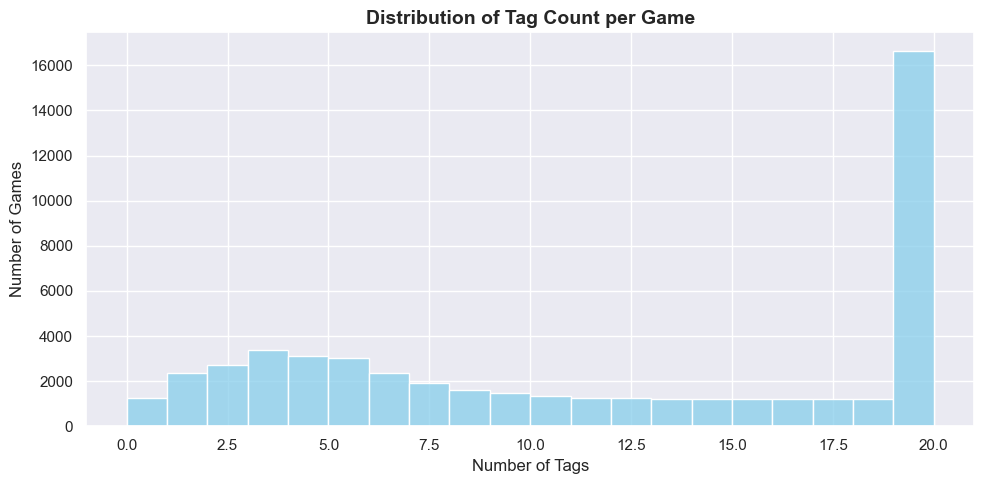

Average number of tags per game: 11.484018713634219


In [ ]:
from collections import Counter
import itertools

def parse_tags(x):
    """Return a list of tags whether the entry is already a list or a comma-separated string."""
    if isinstance(x, list):
        return [t.strip() for t in x]
    elif isinstance(x, str):
        return [t.strip() for t in x.split(',')]
    else:
        return []

# Apply parser
all_tags = df['tags'].dropna().apply(parse_tags)

# Flatten all tags into one list
flat_tags = list(itertools.chain.from_iterable(all_tags))

# Count tag frequencies
tag_counts = Counter(flat_tags).most_common(20)

# Convert to DataFrame for plotting
tag_df = pd.DataFrame(tag_counts, columns=['Tag', 'Count'])

plt.figure(figsize=(10,7))
sns.barplot(x='Count', y='Tag', data=tag_df, palette='mako')
plt.title("Top 20 Most Common Tags", fontsize=14, weight='bold')
plt.xlabel("Count", fontsize=12)
plt.ylabel("Tag", fontsize=12)
plt.tight_layout()
plt.show()

df['tag_count'] = df['tags'].apply(
    lambda x: len(x) if isinstance(x, list) else len(x.split(',')) if isinstance(x, str) else 0
)

plt.figure(figsize=(10,5))
sns.histplot(df['tag_count'], bins=20, kde=False, color='skyblue')
plt.title("Distribution of Tag Count per Game", fontsize=14, weight='bold')
plt.xlabel("Number of Tags", fontsize=12)
plt.ylabel("Number of Games", fontsize=12)
plt.tight_layout()
plt.show()

print("Average number of tags per game:", df['tag_count'].mean())


## 11. Utforskning av textinbäddningar (TF-IDF)

Här testar vi om textbeskrivningar kan bilda meningsfulla kluster.


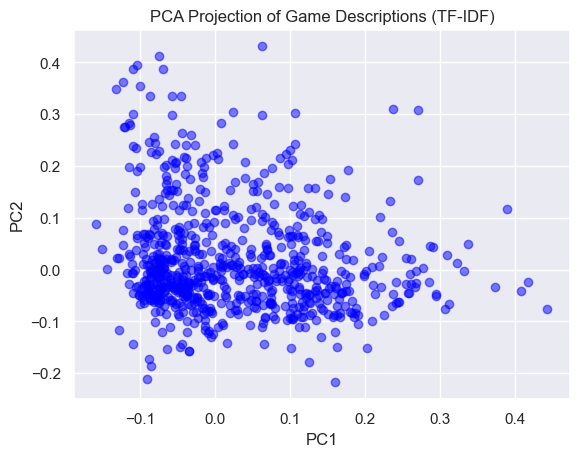

In [34]:
sample_desc = df['description'].fillna("").sample(1000, random_state=42)
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
tfidf_matrix = vectorizer.fit_transform(sample_desc)

pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix.toarray())

plt.scatter(reduced[:,0], reduced[:,1], alpha=0.5, c='blue')
plt.title("PCA Projection of Game Descriptions (TF-IDF)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## 12. Relation mellan popularitet och recensioner


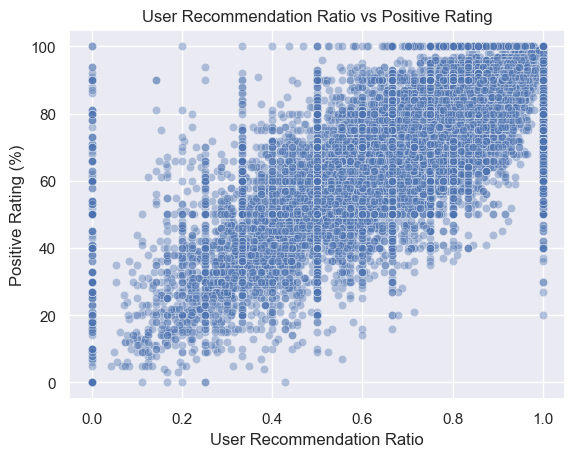

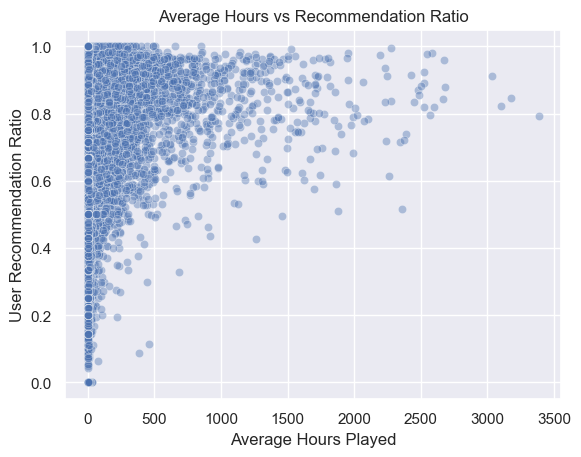

In [35]:
sns.scatterplot(x='recommend_ratio', y='positive_ratio', data=df, alpha=0.4)
plt.title("User Recommendation Ratio vs Positive Rating")
plt.xlabel("User Recommendation Ratio")
plt.ylabel("Positive Rating (%)")
plt.show()

sns.scatterplot(x='avg_hours', y='recommend_ratio', data=df, alpha=0.4)
plt.title("Average Hours vs Recommendation Ratio")
plt.xlabel("Average Hours Played")
plt.ylabel("User Recommendation Ratio")
plt.show()


## 13. Insights Summary

De flesta spel har en positiv andel över 70 %, vilket visar på en recensionsbias mot positiva omdömen.

Antal recensioner och rekommendationsandelar följer power-law-fördelningar — några mycket populära spel dominerar.

Textbaserade funktioner (beskrivning & taggar) är rika och kan representera innehållslikhet.

Genomsnittlig speltid korrelerar måttligt med rekommendationsandel, vilket antyder att längre spel ofta uppskattas mer.

Windows dominerar plattformstillgängligheten (~95 %).

Tidsmässiga trender visar en topp i spelutgivningar kring 2016–2019, följt av en nedgång.

Korrelationsanalysen tyder på att vi kan bygga:

- En innehållsbaserad modell (taggar + beskrivning)

- En samarbetsbaserad modell (user_id, app_id, is_recommended)

- En hybridmodell som väger innehållslikhet mot popularitet och rekommendationsandelar
